In [8]:
import cv2, os
import numpy as np
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
!rm -rf sample_data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/Style Transfer/images"

IMG_WDTH = int(50 * 1.5)
IMG_HGH = int(37 * 1.5)

In [60]:
import cv2
import numpy as np

def extract_patches(image, patch_size=5, stride=1):
    height, width = image.shape[:2]
    patches = []
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    return np.array(patches)

def calculate_features(patch):
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    mean_color = np.mean(gray_patch)
    std_dev = np.std(gray_patch)
    return mean_color, std_dev

def style_transfer(content_img, style_img, patch_size=5, stride=1):
    content_patches = extract_patches(content_img, patch_size, stride)
    style_patches = extract_patches(style_img, patch_size, stride)

    result_img = np.zeros_like(content_img)
    height, width = content_img.shape[:2]
    patch_h, patch_w = patch_size, patch_size

    print(f"Patch count\t content: {len(content_patches)} style: {len(style_patches)}")

    for i, content_patch in enumerate(content_patches):
        content_mean, content_std = calculate_features(content_patch)

        best_match_idx = np.argmin([np.sum((content_mean - style_mean)**2 + (content_std - style_std)**2)
                                    for style_mean, style_std in map(calculate_features, style_patches)])

        y = (i // (width // stride)) * stride
        x = (i % (width // stride)) * stride

        # Handle edges (adjust patch dimensions and slicing for assignment)
        h = min(patch_h, content_img.shape[0] - y)
        w = min(patch_w, content_img.shape[1] - x)

        result_img[y:y + h, x:x + w] = style_patches[best_match_idx][:h, :w]

     # Handle overlapping regions
    overlap_counts = np.zeros_like(result_img)
    for patch in extract_patches(result_img, patch_size, stride=1):
        overlap_counts[y:y + patch_h, x:x + patch_w] += 1

    # Divide and explicitly convert to uint8
    # result_img /= overlap_counts
    # result_img = result_img.astype(np.uint8)

    return result_img.astype(np.uint8) , overlap_counts

# Load your content and style images (assuming they are 100x100)
content_img = cv2.imread('content.png', cv2.IMREAD_COLOR)  # Read only 100x100 region
style_img = cv2.imread('mosaic_style.png', cv2.IMREAD_COLOR)   # Read only 100x100 region

In [61]:
def load_images():
    content_images = []
    for ci in os.listdir(f"{ROOT_DIR}/content/"):
        cimg = cv2.imread(f'{ROOT_DIR}/content/{ci}', cv2.IMREAD_COLOR)
        cimg = cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB)
        cimg = cv2.resize(cimg, (IMG_WDTH, IMG_HGH))
        content_images.append(cimg)

    style_images = []
    for si in os.listdir(f"{ROOT_DIR}/style/"):
        simg = cv2.imread(f'{ROOT_DIR}/style/{si}', cv2.IMREAD_COLOR)
        simg = cv2.cvtColor(simg, cv2.COLOR_BGR2RGB)
        simg = cv2.resize(simg, (IMG_WDTH, IMG_HGH))
        style_images.append(simg)

    return content_images, style_images

In [62]:
def get_stylized_rgb(st_img):
    new_img = st_img[0] / (st_img[1] + 1)
    new_img = new_img.astype(np.uint8)

    return new_img

In [63]:
content_images, style_images = load_images()

In [64]:
stylized_images = []
for content_img, style_img in zip(content_images, style_images):
    st_img = style_transfer(content_img, style_img, patch_size=2, stride=2)
    stylized_images.append(st_img)

Patch count	 content: 999 style: 999
Patch count	 content: 999 style: 999
Patch count	 content: 999 style: 999


(-0.5, 49.5, 36.5, -0.5)

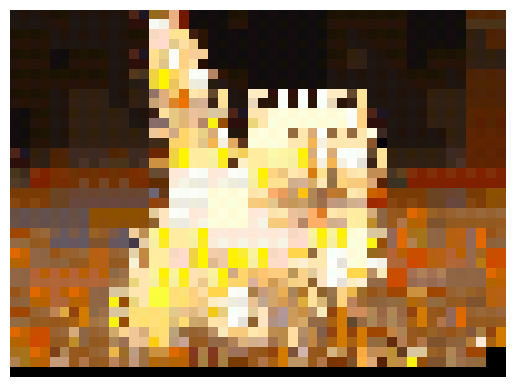

In [65]:
new_img = stylized_img[0] / (stylized_img[1] + 1)
new_img = new_img.astype(np.uint8)
rgb_image = new_img[:, :, ::-1]

plt.imshow(rgb_image)
plt.axis("off")

# **3. Plotting**

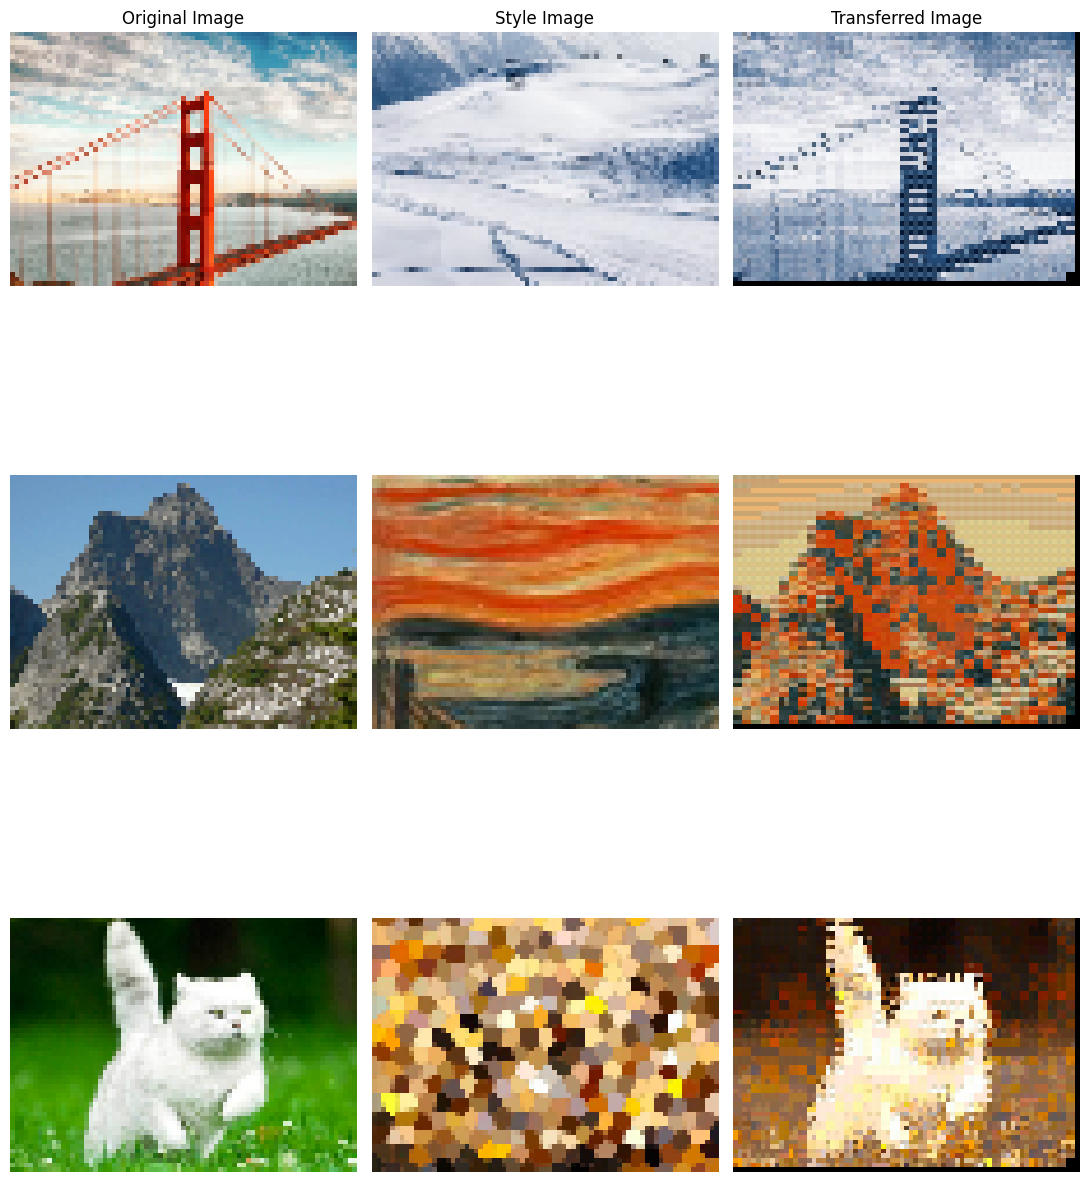

In [69]:
fig, axs = plt.subplots(3, 3, figsize=(11, 15))

# Naming columns
axs[0, 0].set_title("Original Image")
axs[0, 1].set_title("Style Image")
axs[0, 2].set_title("Transferred Image")


for i in range(3):
    axs[i, 0].imshow(content_images[i])
    axs[i, 1].imshow(style_images[i])
    axs[i, 2].imshow(get_stylized_rgb(stylized_images[i]))

    # Turning off axis coords
    axs[i, 0].axis("off")
    axs[i, 1].axis("off")
    axs[i, 2].axis("off")

plt.axis('off')
plt.tight_layout()
plt.show()